# Computational Finance

## Lab Assignment 4

This notebook makes use of python 3 environment by default.

Authors:
   - Kevin de Vries
   - TBA
   
Student Numbers:
   - 10579869
   - 00000000

In [223]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

# Part 1: Approximating a PDF

In [224]:
def char_normal(u,char_params):
    """
    Characteristic function of the standard normal distribution
    """
    return np.exp(-0.5 * u**2)

def fourier_cos_coef(n,a,b,char_func,char_params):
    """
    Calculates the Fourier Cosine coefficients for the
    Fourier Cosine approximation
    """
    euler = np.cos(n*np.pi*a/(b-a)) - 1j*np.sin(n*np.pi*a/(b-a))
    temp = char_func(n*np.pi/(b-a),char_params) * euler
    return 2 / (b-a) * temp.real

def fourier_cos_approx(x,N,a,b,char_func=char_normal,char_params=None):
    """
    Calculates the Fourier Cosine approximation of a PDF
    given by its characteristic function
    
    x: float
        Value for which to evaluate the approximated distribution
    N: integer
        Number of cosines (precision) to approximate the distribution with
    a: float
        Lower boundary of the aproximated integral
    b: float
        Upper boundary of the approximated integral
    char_func: function pointer
        Characteristic function of the PDF
    """
    
    n = np.arange(0,N+1)
    Fn = fourier_cos_coef(n,a,b,char_func,char_params)
    
    terms = Fn[None,:] * np.cos(n*np.pi*(x[:,None]-a)/(b-a))
    terms[:,0] *= 0.5
    
    return np.sum(terms,axis=1)

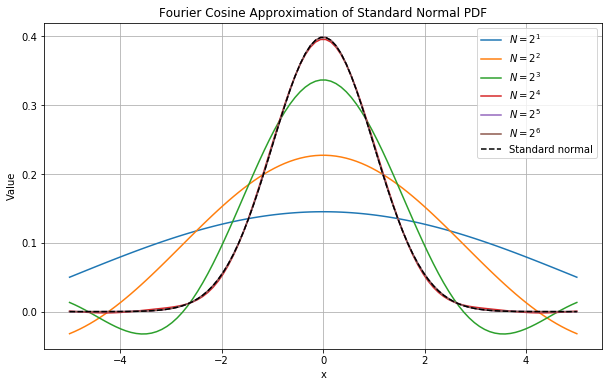

In [225]:
a,b = -10,10
num = 100

x = np.linspace(-5,5,num)

res = np.empty((6,num))
for k in range(1,7):
    res[k-1,:] = fourier_cos_approx(x,2**k,a,b)

    
plt.figure(figsize=(10,6))
plt.title("Fourier Cosine Approximation of Standard Normal PDF")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid(True)

for k in range(1,7):
    plt.plot(x,res[k-1,:],label=r"$N=2^%i$" % (k))

plt.plot(x,norm.pdf(x),'k--',label="Standard normal")
plt.legend()
plt.show()

# Part 2: Calculating an option price

In [226]:
# Black Scholes formula
def black_scholes(r, K, T, S_0, sigma, call=True):
    '''
    Calculates the Hedge ratio, call or put price
    
    Parameters
        r: float
            Interest rate
        K: float
            Strike price
        T: int
            Time of maturity
        S_0: float
            Current stock price
        sigma: float
            Volatility
        call: bool
            check if call or put
        
    Returns
        delta: float
            Hedge ratio
        price: float
            Call or put price
    '''
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*(T**0.5) 
    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    N3 = norm.cdf(-d1)
    N4 = norm.cdf(-d2)
    
    if call:
        price = S_0*N1 - K*np.exp(-r*T)*N2
        delta = N1
    else:
        price = K*np.exp(-r*T)*N4 - S_0*N3
        delta = N1 - 1
    
    return delta, price 

def char_GBM(u,char_params):
    """
    Characteristic function of the Geometric Brownian Motion
    used for a European option
    """
    
    S0,K,r,sigma,t = char_params
    
    phi_GBM = np.exp(1j*u*(r-0.5*sigma**2)*t - 0.5*sigma**2*t*u**2)
    
    return np.exp(1j*u*np.log(S0/K)) * phi_GBM
    #return phi_GBM

def European_call_cos_coef(k,a,b,K):
    """
    Calculates the Fourier Cosine coefficients for
    a European call option
    """
        
    # Calculate chi terms
    chi_scale = 1 / (1 + (k*np.pi / (b-a))**2)
    
    chi1 = np.cos(k*np.pi)*np.exp(b)
    chi2 = np.cos(k*np.pi*-a/(b-a))
    
    chi3 = k*np.pi/(b-a)*np.sin(k*np.pi)*np.exp(b)
    chi4 = k*np.pi/(b-a)*np.sin(k*np.pi*-a/(b-a))
    
    # Combine chi terms to create chi
    chi = chi_scale*(chi1 - chi2 + chi3 - chi4)
        
    # Initialize psi
    psi = np.empty(k.shape)
    
    # Calculate psi
    psi[1:] = (b-a)/(k[1:]*np.pi)*(np.sin(k[1:]*np.pi) - np.sin(k[1:]*np.pi*-a/(b-a)))
    psi[0] = b
        
    return 2 / (b-a) * K * (chi - psi)

def European_call_cos_approx(N,S0,K,r,sigma,t):
    """
    Approximates the value of a European call option
    using the COS method
    """
    
    a = np.log(S0/K) + r*T - 12*sigma*np.sqrt(T)
    b = np.log(S0/K) + r*T + 12*sigma*np.sqrt(T)
    
    k = np.arange(0,N+1)
    
    Fk = fourier_cos_coef(k,a,b,char_GBM,(S0,K,r,sigma,t))
    Gk = European_call_cos_coef(k,a,b,K)   
    
    terms = Fk*Gk
    
    # The F0 term weighs for half its value
    terms[0] *= 0.5
    
    return np.exp(-r*t) * (b-a) / 2 * np.sum(terms)

In [227]:
r,sigma,T = 0.06,0.3, 1
S0,K = 110,110

N = 64

cos_value = European_call_cos_approx(N,S0,K,r,sigma,T)
BS_value = black_scholes(r,K,T,S0,sigma)[1]

print("COS method price: %f" % cos_value)
print("Black-Scholes price: %f" % BS_value)

COS method price: 16.188780
Black-Scholes price: 16.188780
